# Text Filtering

In [1]:
import pandas as pd
import re
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
# Dictionary Long Covid Symptoms
symptom_categories = {
    "Blood Clotting Disorders": [
        "Blood Clotting", "Blood Clots", "Thrombosis", "Pulmonary Embolism",
        "Deep Vein Thrombosis", "Clotting Issues"
    ],
    "Smell Disorders": [
        "Anosmia", "Parosmia", "Distorted Smell", "Smell Loss",
        "Loss of Smell", "Altered Sense of Smell"
    ],
    "Cognitive Symptoms": [
        "Brain Fog", "Cognitive Impairment", "Mental Fogginess", "Confusion",
        "Lack of Focus", "Memory Problems"
    ],
    "Respiratory Symptoms": [
        "Breathlessness", "Shortness of Breath", "Difficulty Breathing",
        "Dyspnea", "Labored Breathing", "Trouble Breathing"
    ],
    "Chest Symptoms": [
        "Chest Pain", "Chest Tightness", "Pressure in Chest",
        "Discomfort in Chest", "Angina"
    ],
    "Cough": [
        "Cough", "Persistent Cough", "Dry Cough", "Chronic Cough",
        "Wet Cough", "Coughing"
    ],
    "General Symptoms": [
        "Fatigue", "Exhaustion", "Tiredness", "Lack of Energy",
        "Extreme Tiredness", "Weakness", "Feeling Drained"
    ],
    "Fever and Chills": [
        "Fever", "High Temperature", "Chills", "Feverish"
    ],
    "Gastrointestinal Symptoms": [
        "Gastrointestinal Problems", "Digestive Issues", "Stomach Problems",
        "Diarrhea", "Nausea", "Vomiting", "Bloating", "Stomach Pain"
    ],
    "Headaches": [
        "Headache", "Migraines", "Severe Headache", "Tension Headache",
        "Throbbing Pain", "Head Pain"
    ],
    "Cardiac Symptoms": [
        "Heart Problems", "Heart Issues", "Heart Palpitations",
        "Irregular Heartbeat", "Chest Fluttering", "Cardiac Issues"
    ],
    "Musculoskeletal Symptoms": [
        "Joint or Muscle Pain", "Muscle Aches", "Muscle Soreness",
        "Joint Pain", "Body Aches", "Arthralgia", "Myalgia"
    ],
    "Mental Health Symptoms": [
        "Mental Problems", "Depression", "Anxiety", "Mood Swings",
        "Mental Health Issues", "Stress", "Panic Attacks", "Irritability"
    ],
    "Dermatological Symptoms": [
        "Skin Rash", "Rashes", "Skin Irritation", "Hives",
        "Dermatitis", "Itchy Skin"
    ],
    "Sleep Disorders": [
        "Sleep Disorders", "Insomnia", "Trouble Sleeping",
        "Disrupted Sleep", "Sleeplessness", "Difficulty Falling Asleep"
    ],
    "Throat Symptoms": [
        "Sore Throat", "Throat Pain", "Throat Irritation",
        "Scratchy Throat", "Swollen Throat"
    ],
    "Autoimmune and Inflammatory Conditions": [
        "Autoimmune Conditions", "Autoimmune Issues", "Lupus",
        "Rheumatoid Arthritis", "Inflammation Disorders", "Chronic Inflammation"
    ],
    "Post-Exertional Malaise (PEM)": [
        "Post-exertional malaise (PEM)", "PEM", "Post-exertional Fatigue",
        "Worsened Fatigue After Activity", "Post-Activity Exhaustion"
    ],
}

In [3]:
df = pd.read_csv("data/all_tweets_clean.csv")

In [4]:
print(f"Jumlah baris: {len(df)}")
df.head()

Jumlah baris: 469588


,Unnamed: 0,date,content,lang,month,weekofyear,quarter
0,0,2022-01-30 23:59:43+00:00,lowkey still hard to believe this was &amp; st...,en,1.0,4.0,1.0
1,1,2022-01-30 23:59:12+00:00,this is a link to the study that shows that fu...,en,1.0,4.0,1.0
2,2,2022-01-30 23:58:21+00:00,we should be using all the currently unusable ...,en,1.0,4.0,1.0
3,3,2022-01-30 23:58:05+00:00,microclotting is the key to understanding and ...,en,1.0,4.0,1.0
4,4,2022-01-30 23:58:05+00:00,"yes. some were in icu for lots of days, a few ...",en,1.0,4.0,1.0


In [5]:
# Membuat daftar semua gejala dan mapping gejala ke kategori
all_symptoms = []
symptom_to_category = {}

for category, symptoms in symptom_categories.items():
    for symptom in symptoms:
        symptom_lower = symptom.lower()
        all_symptoms.append(symptom_lower)
        symptom_to_category[symptom_lower] = category

In [6]:
print(f"jumlah gejala : {len(all_symptoms)}")
print(f"jumlah kategori gejala: {len(symptom_categories.keys())}")

jumlah gejala : 109
jumlah kategori gejala: 18


In [7]:
# Enable tqdm for pandas
tqdm.pandas()

# Create a regex pattern to match any of the symptoms
pattern = '|'.join([re.escape(symptom) for symptom in all_symptoms ])

# Filter rows containing any of the symptoms with progress tracking
print("Filtering rows based on symptoms...")
filtered_df = df[df['content'].progress_apply(lambda x: bool(re.search(pattern, x, re.IGNORECASE)))]

Filtering rows based on symptoms...


100%|████████████████████████████████████████████████████████████████████████| 469588/469588 [01:26<00:00, 5412.05it/s]


In [8]:
# Initialize Counter for occurrences
symptom_counts = Counter()

# Count occurrences of each symptom with progress tracking
print("Counting occurrences of each symptom...")
for symptom in tqdm(all_symptoms, desc="Counting Symptoms"):
    # Use apply to count occurrences row by row
    symptom_counts[symptom] = filtered_df['content'].apply(lambda x: len(re.findall(re.escape(symptom), x, re.IGNORECASE))).sum()

# Convert counts to DataFrame for display
symptom_counts_df = pd.DataFrame(symptom_counts.items(), columns=['Symptom', 'Count'])

Counting occurrences of each symptom...


Counting Symptoms: 100%|█████████████████████████████████████████████████████████████| 109/109 [00:14<00:00,  7.62it/s]


In [ ]:
# 2. Define a function to get the category of a symptom
def get_category(symptom):
    symptom_lower = symptom.lower()
    return symptom_to_category.get(symptom_lower, 'Unknown')

# 4. Apply the function to create the 'Category' column
symptom_counts_df['Category'] = symptom_counts_df['Symptom'].apply(get_category)

# Display the updated DataFrame
print(symptom_counts_df)

In [25]:
symptom_counts_df.to_excel("data/symptom_counts.xlsx", index=False)

In [9]:
print(f"jumlah baris filtered_df : {len(filtered_df)}")

jumlah baris filtered_df : 36367


In [10]:
print(f"jumlah gejala yang terjadi : {symptom_counts_df.Count.sum()}")

jumlah gejala yang terjadi : 51108


In [11]:
filtered_df.head()

,Unnamed: 0,date,content,lang,month,weekofyear,quarter
6,6,2022-01-30 23:55:57+00:00,masks can be a challenge for people w breathle...,en,1.0,4.0,1.0
18,18,2022-01-30 23:50:13+00:00,take it easy - long covid risk increases with ...,en,1.0,4.0,1.0
27,27,2022-01-30 23:47:21+00:00,#longcovid &amp; the brain: uc san francisco r...,en,1.0,4.0,1.0
34,34,2022-01-30 23:45:27+00:00,lung abnormalities found in long covid patient...,en,1.0,4.0,1.0
38,38,2022-01-30 23:44:22+00:00,the bell’s disability scale is a great tool fo...,en,1.0,4.0,1.0


In [13]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation except apostrophes
    text = re.sub(r"[^\w\s']", ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Fungsi untuk mengekstrak gejala dari teks
def extract_symptoms(text):
    extracted_symptoms = []
    # Mencari gejala dengan multiple kata
    for symptom in all_symptoms:
        if symptom in text:
            extracted_symptoms.append(symptom)
    # Fuzzy matching untuk kata yang tidak cocok
    words = text.split()
    for word in words:
        if word not in all_symptoms:
            match, score = process.extractOne(word, all_symptoms, scorer=fuzz.token_sort_ratio)
            if score >= 90:
                extracted_symptoms.append(match)
    return list(set(extracted_symptoms))

# Fungsi untuk mendapatkan kategori dari gejala
def get_categories(symptoms):
    categories = set()
    for symptom in symptoms:
        category = symptom_to_category.get(symptom)
        if category:
            categories.add(category)
    return list(categories)

filtered_df["clean_text"] = filtered_df['content'].progress_apply(preprocess_text)

# Extract symptoms with progress monitoring
filtered_df['extracted_symptoms'] = filtered_df['clean_text'].progress_apply(extract_symptoms)

# Get symptom categories with progress monitoring
filtered_df['symptom_categories'] = filtered_df['extracted_symptoms'].progress_apply(get_categories)

100%|█████████████████████████████████████████████████████████████████████████| 36367/36367 [00:00<00:00, 68360.45it/s]
C:\Users\alfadoraflyh\AppData\Local\Temp\ipykernel_8308\3978202478.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["clean_text"] = filtered_df['content'].progress_apply(preprocess_text)
100%|████████████████████████████████████████████████████████████████████████████| 36367/36367 [14:15<00:00, 42.49it/s]
C:\Users\alfadoraflyh\AppData\Local\Temp\ipykernel_8308\3978202478.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [17]:
filtered_df['symptom_categories']

6                           [Respiratory Symptoms]
18                                [Chest Symptoms]
27                            [Cognitive Symptoms]
34                          [Respiratory Symptoms]
38                 [Post-Exertional Malaise (PEM)]
                            ...                   
469551                                 [Headaches]
469562    [Autoimmune and Inflammatory Conditions]
469565                                     [Cough]
469566                 [Chest Symptoms, Headaches]
469580                  [Blood Clotting Disorders]
Name: symptom_categories, Length: 36367, dtype: object

In [21]:
filtered_df.to_excel("data/filtered_data_with_category.xlsx", index=False)

In [20]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)


C:\Users\alfadoraflyh\AppData\Local\Temp\ipykernel_8308\347174173.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


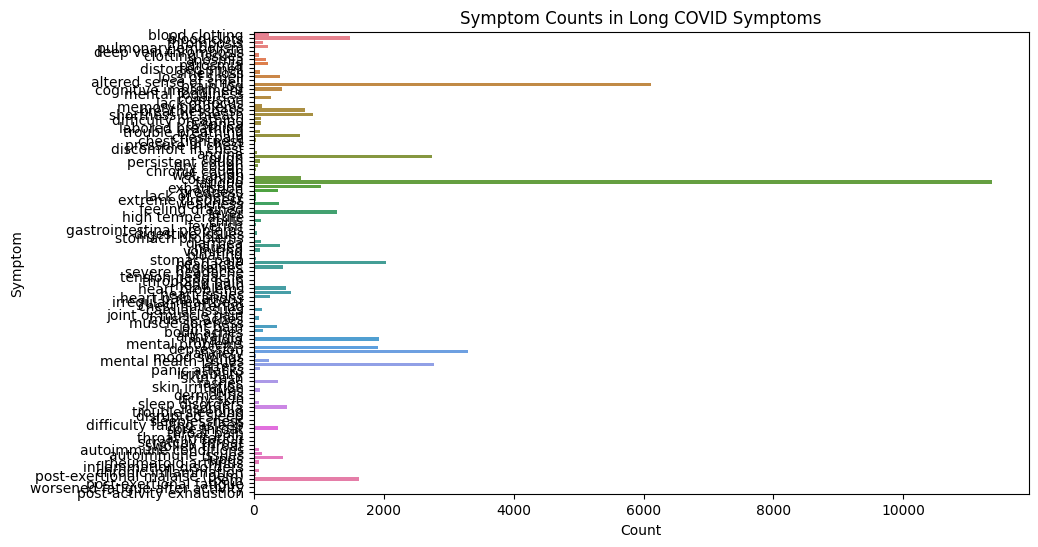

In [14]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a unique color palette based on the number of symptoms
palette = sns.color_palette("husl", len(symptom_counts_df))

# Plot a horizontal bar chart
sns.barplot(
    x='Count', 
    y='Symptom', 
    data=symptom_counts_df, 
    palette=palette
)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Symptom')
plt.title('Symptom Counts in Long COVID Symptoms')

# Display the plot
plt.show()

# Convert Excel into JSON Format

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("data/filtered_data_with_category_labeling.xlsx")

In [3]:
df.head()

,date,content,extracted_symptoms,symptom_categories
0,2022-01-30 23:55:57+00:00,masks can be a challenge for people w breathle...,['breathlessness'],['Respiratory Symptoms']
1,2022-01-30 23:50:13+00:00,take it easy - long covid risk increases with ...,['chest tightness'],['Chest Symptoms']
2,2022-01-30 23:47:21+00:00,#longcovid &amp; the brain: uc san francisco r...,['brain fog'],['Cognitive Symptoms']
3,2022-01-30 23:45:27+00:00,lung abnormalities found in long covid patient...,['breathlessness'],['Respiratory Symptoms']
4,2022-01-30 23:44:22+00:00,the bell’s disability scale is a great tool fo...,['pem'],['Post-Exertional Malaise (PEM)']


In [6]:
df.to_json("data/dataset_for_labeling.json", orient='records', indent=4, force_ascii=False)